In [1]:
#import library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.utils import class_weight
import numpy as np
import zipfile, os

In [2]:
# ==========================
# 1. Parameter & Path
# ==========================
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30

base_dir = "D:\KULIAH UNDIP\SKRIPSI S NYA SANTUY\DATASET\Dataset New"  

train_path = os.path.join(base_dir, "train")  
test_path = os.path.join(base_dir, "test")  

In [3]:
# ==========================
# 2. Data Augmentation
# ==========================
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomTranslation(0.1, 0.1),
])


In [4]:
# ==========================
# 3. Load Dataset
# ==========================
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=123
)

# Hanya load test_ds (tanpa val_ds)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False  
)

class_names = train_ds.class_names
num_classes = len(class_names)

Found 2647 files belonging to 3 classes.
Found 1137 files belonging to 3 classes.


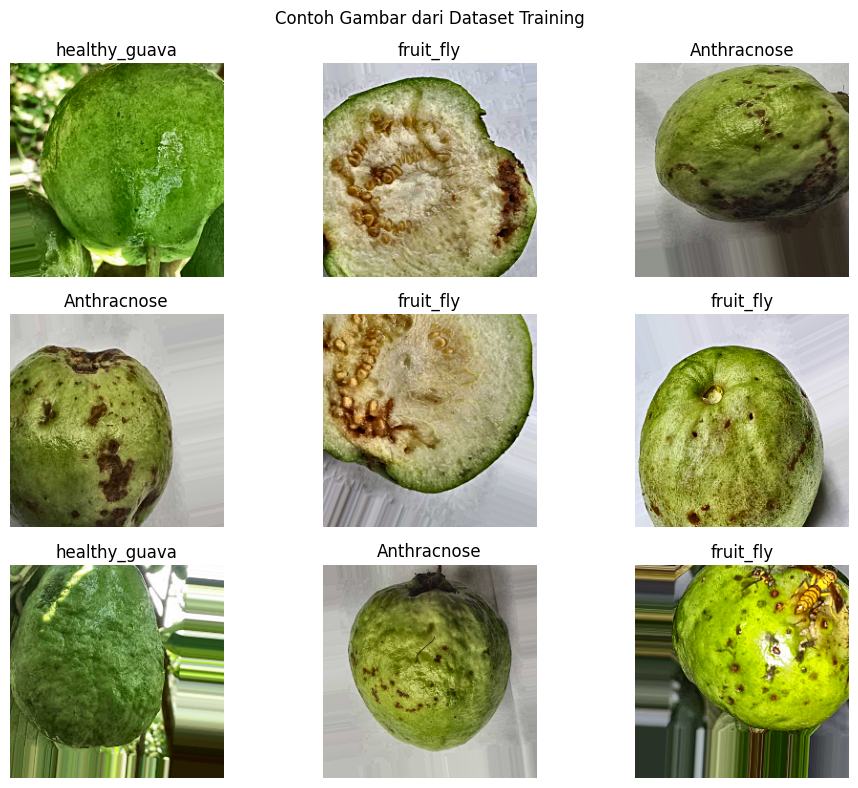

In [5]:
# Visualisasi beberapa gambar dari dataset training
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label_idx = tf.argmax(labels[i]).numpy()
        plt.title(class_names[label_idx])
        plt.axis("off")
plt.suptitle("Contoh Gambar dari Dataset Training")
plt.tight_layout()
plt.show()

In [6]:
# ==========================
# 4. EfficientNetB0 + Fine-Tuning
# ==========================
base_model = tf.keras.applications.MobileNetV3Small(
    include_top=False,
    weights='imagenet',
    input_shape=IMAGE_SIZE + (3,)
)
base_model.trainable = True  # Fine-tune semua layer

inputs = layers.Input(shape=IMAGE_SIZE + (3,))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v3.preprocess_input(x)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(64, activation='relu', kernel_regularizer='l2')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)


4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [7]:
# ==========================
# 5. Class Weights (Optional)
# ==========================
# Flatten labels for class_weight
y_train = np.concatenate([y for x, y in train_ds], axis=0)
y_labels = np.argmax(y_train, axis=1)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_labels), y=y_labels)
class_weights = dict(enumerate(class_weights))

In [8]:
# ==========================
# 6. Compile Model
# ==========================
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [9]:
# ==========================
# 7. Callbacks
# ==========================
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=5)
]

In [10]:
# ==========================
# 8. Train
# ==========================
history = model.fit(
    train_ds,
    validation_data=test_ds,  # Gunakan test_ds sebagai validasi
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 42s 385ms/step - accuracy: 0.6210 - loss: 1.9602 - val_accuracy: 0.8461 - val_loss: 1.5071 - learning_rate: 1.0000e-04
Epoch 2/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9488 - loss: 1.2493 - val_accuracy: 0.8461 - val_loss: 1.3857 - learning_rate: 1.0000e-04
Epoch 3/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9658 - loss: 1.1007 - val_accuracy: 0.8734 - val_loss: 1.2245 - learning_rate: 1.0000e-04
Epoch 4/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 69s 832ms/step - accuracy: 0.9863 - loss: 0.9547 - val_accuracy: 0.9112 - val_loss: 1.0677 - learning_rate: 1.0000e-04
Epoch 5/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 60s 725ms/step - accuracy: 0.9874 - loss: 0.8531 - val_accuracy: 0.8936 - val_loss: 1.0010 - learning_rate: 1.0000e-04
Epoch 6/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 63s 758ms/step - accuracy: 0.9872 - loss: 0.7700 - val_accuracy: 0.9516 - val_loss: 0.8008 - learning_rate: 1.0000e-04
Epoch 7/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 61s 729ms/step - acc

In [11]:
# ==========================
# 9. Evaluate
# ==========================
loss, acc = model.evaluate(test_ds)
print(f"\nTest Accuracy: {acc:.4f}")


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.9996 - loss: 0.0168

Test Accuracy: 0.9991


In [12]:
# ==========================
# 10. Classification Report
# ==========================
from sklearn.metrics import classification_report


y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for x, y in test_ds])
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Tampilkan classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step

Classification Report:
               precision    recall  f1-score   support

  Anthracnose       1.00      1.00      1.00       464
    fruit_fly       1.00      1.00      1.00       394
healthy_guava       1.00      1.00      1.00       279

     accuracy                           1.00      1137
    macro avg       1.00      1.00      1.00      1137
 weighted avg       1.00      1.00      1.00      1137



In [13]:
# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
# Confusion Matrix

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


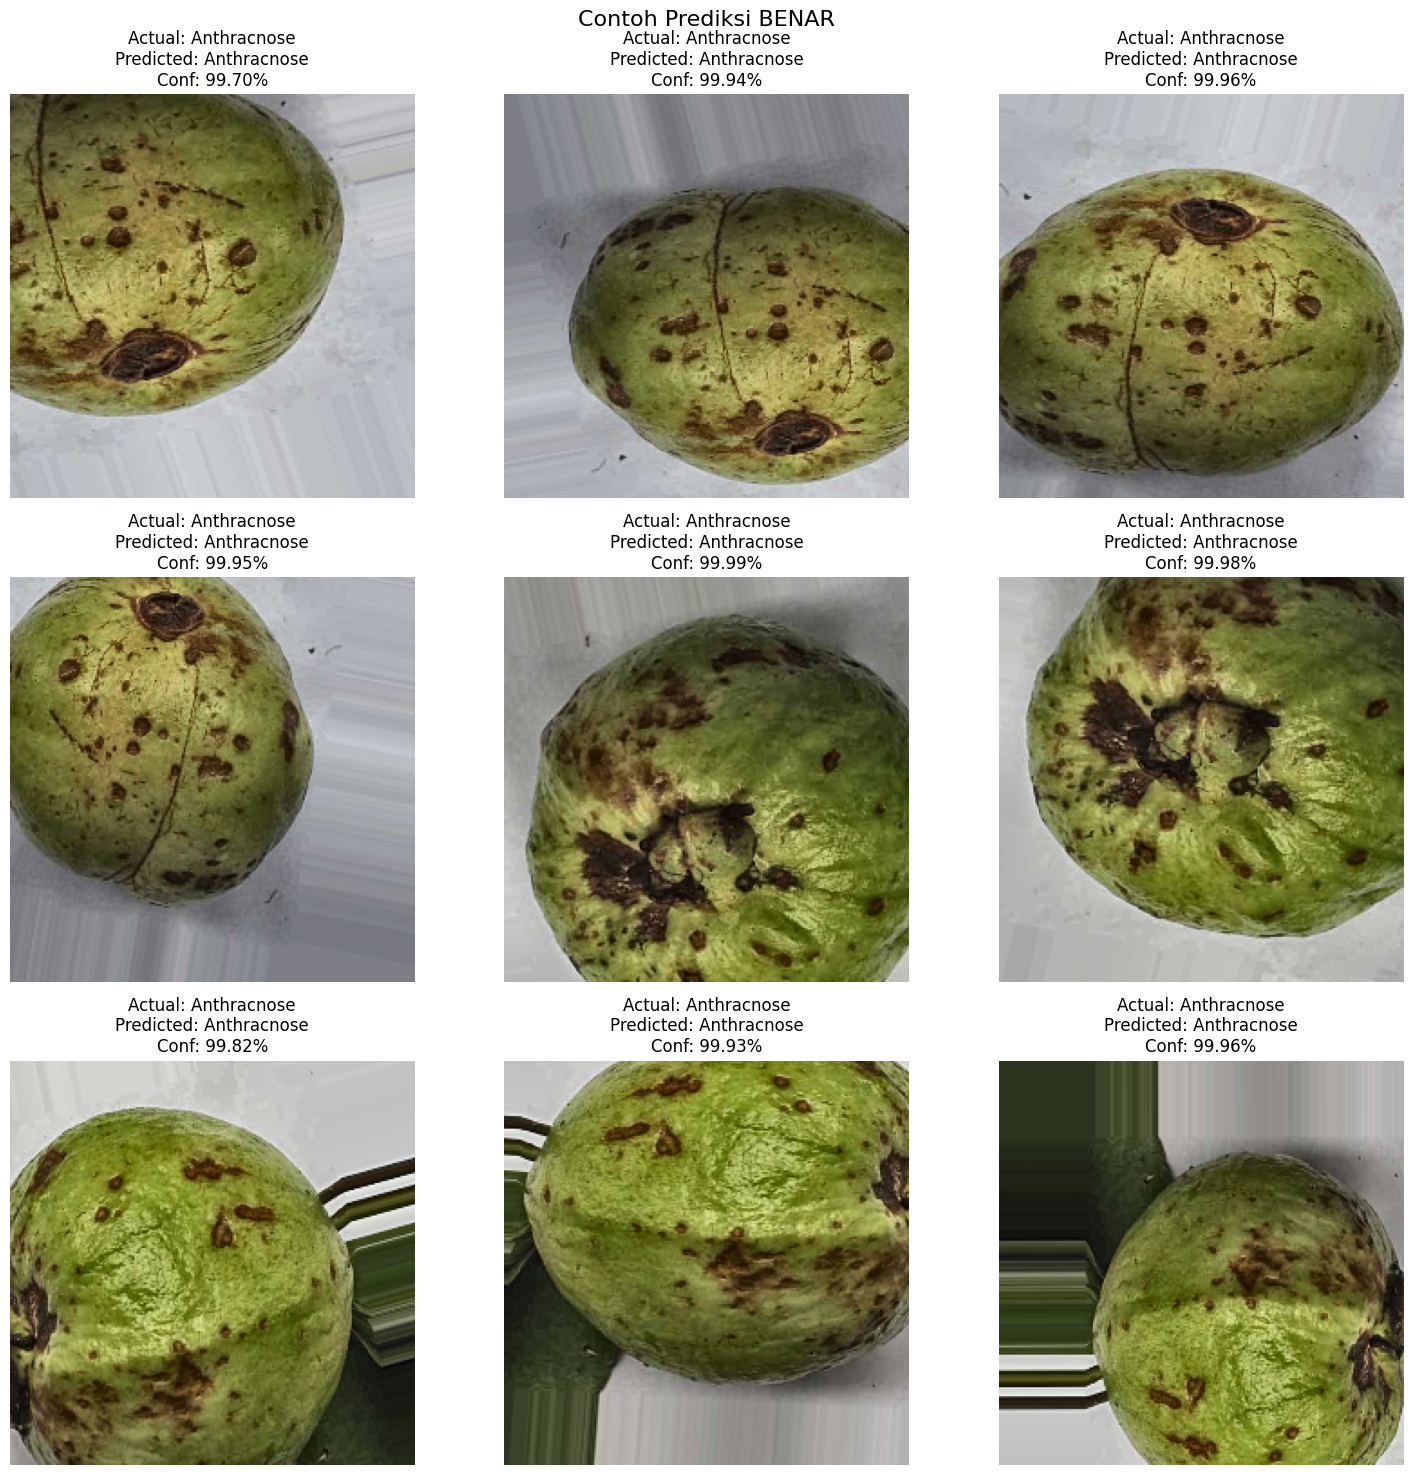

In [15]:
# Cell 16: Visualize Correct Predictions

plt.figure(figsize=(15, 15))
shown = 0

for images, labels in test_ds.unbatch().batch(1):
    predictions = model.predict(images)
    pred_class = np.argmax(predictions[0])
    true_class = np.argmax(labels[0])

    if pred_class == true_class:
        ax = plt.subplot(3, 3, shown + 1)
        plt.imshow(images[0].numpy().astype("uint8"))
        plt.title(f"Actual: {class_names[true_class]}\nPredicted: {class_names[pred_class]}\nConf: {np.max(predictions[0])*100:.2f}%")
        plt.axis("off")
        shown += 1
        if shown == 9:
            break

plt.suptitle("Contoh Prediksi BENAR", fontsize=16)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━

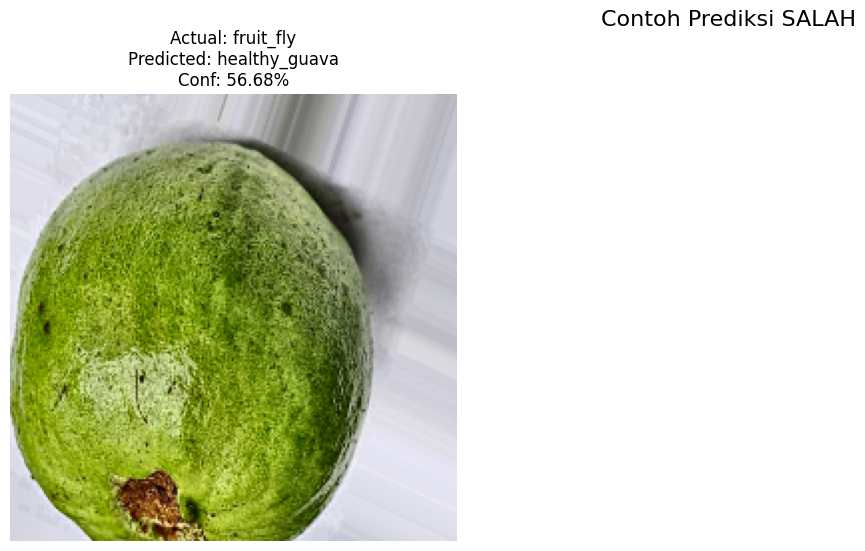

In [16]:
# Cell 17: Visualize Wrong Predictions

plt.figure(figsize=(15, 15))
shown = 0

for images, labels in test_ds.unbatch().batch(1):
    predictions = model.predict(images)
    pred_class = np.argmax(predictions[0])
    true_class = np.argmax(labels[0])

    if pred_class != true_class:
        ax = plt.subplot(3, 3, shown + 1)
        plt.imshow(images[0].numpy().astype("uint8"))
        plt.title(f"Actual: {class_names[true_class]}\nPredicted: {class_names[pred_class]}\nConf: {np.max(predictions[0])*100:.2f}%")
        plt.axis("off")
        shown += 1
        if shown == 9:
            break

plt.suptitle("Contoh Prediksi SALAH", fontsize=16)
plt.tight_layout()
plt.show()
